In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import import_ipynb


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
csvClean = 'tweetsLimpios.csv'
tweetsLimpiosDF = pd.read_csv(csvClean,index_col=0)
tweetsLimpiosDF.head()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


mensaje  sentimiento
0  awww that bummer you shoulda got david carr of...            0
1  is upset that he can not update his facebook b...            0
2  dived many times for the ball managed to save ...            0
3     my whole body feels itchy and like its on fire            0
4  no it not behaving at all mad why am here beca...            0

In [3]:
#aunque en el momento en el que estoy desarrollando este proyecto al generar el CSV no existe
#nulos, procedo a la eliminación por si se decidiese en trabajos futuros entrenar
#el modelo con otro dataset
tweetsLimpiosDF.dropna(inplace=True)
tweetsLimpiosDF.reset_index(drop=True,inplace=True)
tweetsLimpiosDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596020 entries, 0 to 1596019
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   mensaje      1596020 non-null  object
 1   sentimiento  1596020 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


## Obtención de datos de entrenamiento, validación y de test

Procedo a la división del conjunto de datos en 3 grupos. 

Conjunto de Entrenamiento. Este grupo utilizará el 90 % del total de los datos<br>
Conjunto de Validación. Este grupo utilizará el 5 % de los datos<br>
Conjunto de test. Este grupo utilizará el otro 5 % de los datos<br>
La decisión de utilizar esta proporción ha sido debido a que el número de datos disponibles es muy elevado y entiendo que un 5% de 1,6 millones de datos es más que suficiente para testear el modelo.

In [4]:
x = tweetsLimpiosDF.mensaje
y = tweetsLimpiosDF.sentimiento

In [5]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [6]:
import plotly.graph_objects as go
labels=["Datos de Entrenamiento", "Datos de Validación", "Datos de Test"]
values = [x_train.count(), x_validation.count(), x_test.count()]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()

Se observa que ahora todos los mensajes son del mismo tamaño 45

In [72]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=["Datos de Entrenamiento", "Datos de Validación", "Datos de Test"],
                             values=[len(x_train), len(x_validation), len(x_test)])])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

## Entrenamiento del modelo

Para el entrenamiento del modelo voy a realizar una comparación con otro modelo que voy a definir como mi modelo base sobre el que voy a comparar el resultado de los modelos que voy a probar para determinar mi clasificador de sentimiento.<br>
Para ello voy a utilizar la librería TextBlob de Python.

In [73]:
from textblob import TextBlob
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score


In [74]:
%%time
resultTextBlob = [TextBlob(i).sentiment.polarity for i in x_validation]
predTextBlob = [0 if n < 0 else 1 for n in resultTextBlob]

Wall time: 2.18 s


In [75]:
conmat = np.array(confusion_matrix(y_validation, predTextBlob, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['positivo', 'negativo'],
                         columns=['pred_positiva','pred_negativa'])
textBlobAccuracy=accuracy_score(y_validation, predTextBlob)*100
print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, predTextBlob)*100))
print ("-"*80)
print ("Matriz de confusión\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
classification_report(y_validation, predTextBlob)
print (classification_report(y_validation, predTextBlob))

Accuracy Score: 61.09%
--------------------------------------------------------------------------------
Matriz de confusión

          pred_positiva  pred_negativa
positivo           7125            791
negativo           5419           2625
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.77      0.33      0.46      8044
           1       0.57      0.90      0.70      7916

    accuracy                           0.61     15960
   macro avg       0.67      0.61      0.58     15960
weighted avg       0.67      0.61      0.58     15960



Como se indicaba con anterioridad mi modelo sobre el que compararé los resultados obtenidos será este cuya tasa de acierto es del 60,98%

## Extracción de características

En todo algoritmo de aprendizaje automático en que se quiera utilizar texto es imprescindible que dicha información se convertida a un valor que sea interpretable a nivel matemático, es decir es necesario transformar ese texto a un valor numérico. Existen multiples formas de acometer este paso tan importante dentro del mundo de machine learning. De entre estos métodos podemos destacar la bolsa de palabras o bag of words.Esta técnica ignora el orden de las palabras así como su gramática. Una vez se crea el corpus, se crea un vocabulario a partir del mismo, y es entonces cuando cada entrada de datos es representado como un vector de tipo numérico en el vocabulario contruido a partir del corpus.

## Count Vectorizer

Voy a utlizar esta técnica que me permite transformar como indicaba anteriormente valores en formato de texto a vectores de tipo numérico. 
Voy a preceder a limitar el tamaño del vocabulario debido al gran número de palabras del mismo, ya que de no limitarlo, estaría cercano a las 300000, que serían el número de columnas de cada vector de entrada por los más de 1,6 millones de mensajes lo cual requeriría un alto grado de procesamiento. 

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [77]:
def baseModel_improvement(pipeline, x_train, y_train, x_test, y_test):
    
    ti = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - ti
    accuracy = accuracy_score(y_test, y_pred)
    accuracy=accuracy*100
    print ("TextBlob accuracy: {0:.2f}%".format(textBlobAccuracy))
    print ("accuracy score: {0:.2f}%".format(accuracy))
    
    if accuracy > textBlobAccuracy:
        print ("El modelo es {0:.2f}% más preciso que el modelo basado en TextBlob".format((accuracy-textBlobAccuracy)))
    elif accuracy == textBlobAccuracy:
        print ("Ambos modelos poseen la misma precisión")
    else:
        print ("El modelo es {0:.2f}% menos preciso que el modelo basado en TextBlob".format((textBlobAccuracy-accuracy)))
    print ("Tiempo de entrenamiento y de test: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    model=sentiment_fit
    return accuracy, train_test_time,model

Defino estas funciones para poder entrenar y evaluar de un modo ágil diferentes modelos

In [78]:
lregression = LogisticRegression()
cVect = CountVectorizer()

num_features = np.arange(10000,100001,10000)

def featureExtract_comparisson(vectorizer=cVect, n_features=num_features, stop_words=None,ngram_range=(1, 1), classifier=lregression):
    result = []
    print (classifier)
    print ("\n")
    for num in num_features:
        vectorizer.set_params(stop_words=stop_words, max_features=num, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Resultado de la validación para  {} features".format(num))
        nfeature_accuracy,tt_time,model = baseModel_improvement(checker_pipeline, x_train, y_train,x_validation, y_validation)
        result.append((num,nfeature_accuracy,tt_time))
    return result,model

In [79]:
from sklearn.externals import joblib

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



### Unigrama

In [15]:
%%time
print ("Resultado Para UNIGRAM CON STOP WORDS\n")
result_UNIGRAM_STOPWORDS,modelo_usw_cv = featureExtract_comparisson(stop_words='english')
joblib.dump(modelo_usw_cv,'.\Modelos Entrenados\modelo_entrenado_usw_cv.pkl')

Resultado Para UNIGRAM CON STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Resultado de la validación para  10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 77.49%
El modelo es 16.40% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 28.84s
--------------------------------------------------------------------------------
Resultado de la validación para  20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 77.89%
El modelo es 16.80% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 29.89s
--------------------------------------------------------------------------------
Resultado de la validación para  30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 77.94%
El modelo es 16.85% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 30.61s
--------------------------------------------------------------------------------
Resultado de la validación para  40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.00%
El modelo es 16.91% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 30.44s
--------------------------------------------------------------------------------
Resultado de la validación para  50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 77.93%
El modelo es 16.84% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 31.18s
--------------------------------------------------------------------------------
Resultado de la validación para  60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.06%
El modelo es 16.97% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 30.71s
--------------------------------------------------------------------------------
Resultado de la validación para  70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 77.93%
El modelo es 16.84% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 37.83s
--------------------------------------------------------------------------------
Resultado de la validación para  80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.04%
El modelo es 16.95% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 31.39s
--------------------------------------------------------------------------------
Resultado de la validación para  90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 77.94%
El modelo es 16.85% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 31.47s
--------------------------------------------------------------------------------
Resultado de la validación para  100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 77.91%
El modelo es 16.82% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 31.21s
--------------------------------------------------------------------------------
Wall time: 5min 16s


['.\\Modelos Entrenados\\modelo_entrenado_usw_cv.pkl']

In [16]:
%%time
print ("Resultado Para UNIGRAM SIN STOP WORDS\n")
result_UNIGRAM_NOSTOPWORDS,modelo_u_cv = featureExtract_comparisson()
joblib.dump(modelo_u_cv,'.\Modelos Entrenados\modelo_entrenado_u_cv.pkl')

Resultado Para UNIGRAM SIN STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Resultado de la validación para  10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 79.61%
El modelo es 18.52% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 32.06s
--------------------------------------------------------------------------------
Resultado de la validación para  20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 79.79%
El modelo es 18.70% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 33.04s
--------------------------------------------------------------------------------
Resultado de la validación para  30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 79.72%
El modelo es 18.63% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 33.70s
--------------------------------------------------------------------------------
Resultado de la validación para  40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 79.80%
El modelo es 18.71% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 33.52s
--------------------------------------------------------------------------------
Resultado de la validación para  50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 79.89%
El modelo es 18.80% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 33.28s
--------------------------------------------------------------------------------
Resultado de la validación para  60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 79.80%
El modelo es 18.71% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 34.13s
--------------------------------------------------------------------------------
Resultado de la validación para  70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 79.72%
El modelo es 18.63% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 33.80s
--------------------------------------------------------------------------------
Resultado de la validación para  80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 79.69%
El modelo es 18.60% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 33.53s
--------------------------------------------------------------------------------
Resultado de la validación para  90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 79.81%
El modelo es 18.72% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 34.32s
--------------------------------------------------------------------------------
Resultado de la validación para  100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 79.77%
El modelo es 18.68% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 34.36s
--------------------------------------------------------------------------------
Wall time: 5min 38s


['.\\Modelos Entrenados\\modelo_entrenado_u_cv.pkl']

### Bigrama

Basándome en lo que se indica en la wikipedia. "Un bigrama o digrama es un grupos de dos letras, dos sílabas, o dos palabras. Los bigramas son utilizados comúnmente como base para el simple análisis estadístico de texto. Se utilizan en uno de los más exitosos modelos de lenguaje para el reconocimiento de voz.1​ Se trata de un caso especial del N-grama."


In [17]:
%%time
print ("Resultado para BIGRAMA SIN STOP WORDS\n")
result_BIGRAM_NOSTOPWORDS,modelo_b_cv = featureExtract_comparisson(ngram_range=(1, 2))
joblib.dump(modelo_b_cv,'.\Modelos Entrenados\modelo_entrenado_b_cv.pkl')

Resultado para BIGRAMA SIN STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Resultado de la validación para  10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 80.38%
El modelo es 19.29% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 59.81s
--------------------------------------------------------------------------------
Resultado de la validación para  20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.12%
El modelo es 20.03% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 64.71s
--------------------------------------------------------------------------------
Resultado de la validación para  30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.40%
El modelo es 20.31% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 66.34s
--------------------------------------------------------------------------------
Resultado de la validación para  40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.63%
El modelo es 20.54% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 67.28s
--------------------------------------------------------------------------------
Resultado de la validación para  50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.74%
El modelo es 20.65% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 65.19s
--------------------------------------------------------------------------------
Resultado de la validación para  60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.86%
El modelo es 20.77% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 65.44s
--------------------------------------------------------------------------------
Resultado de la validación para  70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.89%
El modelo es 20.80% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 66.84s
--------------------------------------------------------------------------------
Resultado de la validación para  80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.76%
El modelo es 20.67% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 69.03s
--------------------------------------------------------------------------------
Resultado de la validación para  90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.82%
El modelo es 20.73% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 71.05s
--------------------------------------------------------------------------------
Resultado de la validación para  100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.86%
El modelo es 20.77% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 71.20s
--------------------------------------------------------------------------------
Wall time: 11min 22s


['.\\Modelos Entrenados\\modelo_entrenado_b_cv.pkl']

In [18]:
%%time
print ("Resultado para BIGRAMA Con STOP WORDS\n")
result_BIGRAM_STOPWORDS,modelo_bsw_cv = featureExtract_comparisson(ngram_range=(1, 2),stop_words='english')
joblib.dump(modelo_bsw_cv,'.\Modelos Entrenados\modelo_entrenado_bsw_cv.pkl')

Resultado para BIGRAMA Con STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Resultado de la validación para  10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 77.65%
El modelo es 16.56% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 52.01s
--------------------------------------------------------------------------------
Resultado de la validación para  20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 77.91%
El modelo es 16.82% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 53.79s
--------------------------------------------------------------------------------
Resultado de la validación para  30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.22%
El modelo es 17.13% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 52.82s
--------------------------------------------------------------------------------
Resultado de la validación para  40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.42%
El modelo es 17.33% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 55.12s
--------------------------------------------------------------------------------
Resultado de la validación para  50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.54%
El modelo es 17.45% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 53.28s
--------------------------------------------------------------------------------
Resultado de la validación para  60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.45%
El modelo es 17.36% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 54.65s
--------------------------------------------------------------------------------
Resultado de la validación para  70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.46%
El modelo es 17.37% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 55.90s
--------------------------------------------------------------------------------
Resultado de la validación para  80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.43%
El modelo es 17.34% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 56.80s
--------------------------------------------------------------------------------
Resultado de la validación para  90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.38%
El modelo es 17.29% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 55.63s
--------------------------------------------------------------------------------
Resultado de la validación para  100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.53%
El modelo es 17.44% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 55.32s
--------------------------------------------------------------------------------
Wall time: 9min 21s


['.\\Modelos Entrenados\\modelo_entrenado_bsw_cv.pkl']

### Trigrama

In [19]:
%%time
print ("Resultado para TRIGRAMA SIN STOP WORDS\n")
result_TRIGRAM_NOSTOPWORDS,modelo_t_cv = featureExtract_comparisson(ngram_range=(1, 3))
joblib.dump(modelo_t_cv,'.\Modelos Entrenados\modelo_entrenado_t_cv.pkl')

Resultado para TRIGRAMA SIN STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Resultado de la validación para  10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 80.29%
El modelo es 19.20% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 136.76s
--------------------------------------------------------------------------------
Resultado de la validación para  20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.24%
El modelo es 20.15% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 118.69s
--------------------------------------------------------------------------------
Resultado de la validación para  30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.44%
El modelo es 20.35% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 115.49s
--------------------------------------------------------------------------------
Resultado de la validación para  40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.73%
El modelo es 20.64% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 117.46s
--------------------------------------------------------------------------------
Resultado de la validación para  50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.74%
El modelo es 20.65% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 122.73s
--------------------------------------------------------------------------------
Resultado de la validación para  60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.95%
El modelo es 20.86% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 127.25s
--------------------------------------------------------------------------------
Resultado de la validación para  70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.97%
El modelo es 20.88% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 124.60s
--------------------------------------------------------------------------------
Resultado de la validación para  80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.22%
El modelo es 21.13% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 138.23s
--------------------------------------------------------------------------------
Resultado de la validación para  90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.15%
El modelo es 21.06% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 139.72s
--------------------------------------------------------------------------------
Resultado de la validación para  100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.22%
El modelo es 21.13% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 154.77s
--------------------------------------------------------------------------------
Wall time: 22min 30s


['.\\Modelos Entrenados\\modelo_entrenado_t_cv.pkl']

In [20]:
%%time
print ("Resultado para TRIGRAMA Con STOP WORDS\n")
result_TRIGRAM_STOPWORDS,modelo_tsw_cv = featureExtract_comparisson(ngram_range=(1, 3),stop_words='english')
joblib.dump(modelo_tsw_cv,'.\Modelos Entrenados\modelo_entrenado_tsw_cv.pkl')

Resultado para TRIGRAMA Con STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Resultado de la validación para  10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 77.63%
El modelo es 16.54% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 105.79s
--------------------------------------------------------------------------------
Resultado de la validación para  20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 77.83%
El modelo es 16.74% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 101.30s
--------------------------------------------------------------------------------
Resultado de la validación para  30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.18%
El modelo es 17.09% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 103.93s
--------------------------------------------------------------------------------
Resultado de la validación para  40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.43%
El modelo es 17.34% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 116.49s
--------------------------------------------------------------------------------
Resultado de la validación para  50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.48%
El modelo es 17.39% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 122.54s
--------------------------------------------------------------------------------
Resultado de la validación para  60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.46%
El modelo es 17.37% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 120.20s
--------------------------------------------------------------------------------
Resultado de la validación para  70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.50%
El modelo es 17.41% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 113.20s
--------------------------------------------------------------------------------
Resultado de la validación para  80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.46%
El modelo es 17.37% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 97.48s
--------------------------------------------------------------------------------
Resultado de la validación para  90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.41%
El modelo es 17.32% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 89.83s
--------------------------------------------------------------------------------
Resultado de la validación para  100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 78.45%
El modelo es 17.36% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 89.20s
--------------------------------------------------------------------------------
Wall time: 18min 17s


['.\\Modelos Entrenados\\modelo_entrenado_tsw_cv.pkl']

## TFIDF Vectorizer-Term Frequency – Inverse Document Frequency 

Determina un valor numérico que define la importancia de una keyword particular dentro de todo un sitio.

Para conocerla frecuencia de un término TF es necesario aplicar el siguiente cálculo para cada una de las palabras que aparecen en un documento o texto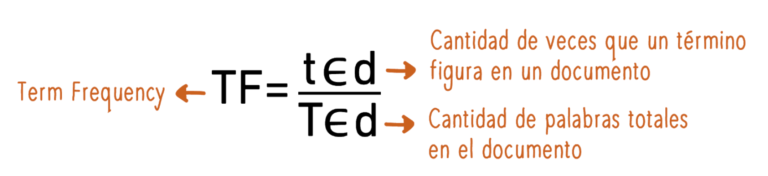


Por ejemplo en las siguientes frases:<br>
    El coche rojo<br>
    El coche nuevo rojo <br>
la tabla de apariciones sería la siguiente:<br>

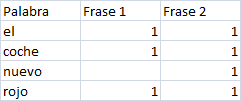


Para calcular la frecuencia de cada término sería necesario aplicar la fórmula anterior. Por ejemplo para la palabra el de la frase 1:<br>
TF ("el";Frase1) = 1/3 = 0,33<br>
el mismo término en la frase 2 sería:<br>
TF ("el";Frase2) = 1/4 = 0,25<br>

Por último para clacular la frecuencia de documentos inversa, sería necesario aplcar la siguiente fórmula:<br>
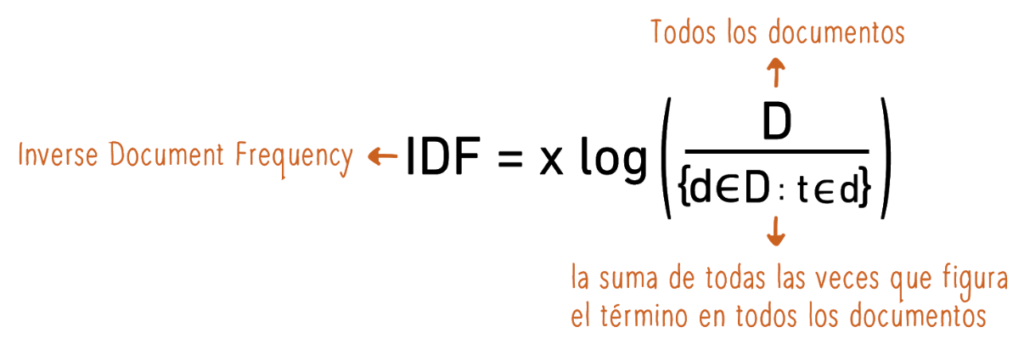

Que trasladado al ejemplo que presento :<br>
<br>
idf("el",D)=log(2/2)=0

Por ultimo una vez tenemos el valor de TF y de IDF ya se podría calcular el valor TF-IDF.<br>
<br>
TF-IDF = TF x IDF<br>
Que aplicado al ejemplo tendríamos un resultado de cero en ambos casos

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [26]:
%%time
print ("Resultado para BIGRAMA sin STOP WORDS (Tfidf)\n")
result_BIGRAM_NOSTOPWORDS_TFIDF,modelo_b_tfidf = featureExtract_comparisson(vectorizer=tvec,ngram_range=(1, 2))
joblib.dump(modelo_b_tfidf,'.\Modelos Entrenados\modelo_entrenado_b_tfidf.pkl')

Resultado para BIGRAMA sin STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Resultado de la validación para  10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 80.68%
El modelo es 19.59% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 61.27s
--------------------------------------------------------------------------------
Resultado de la validación para  20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.45%
El modelo es 20.36% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 62.51s
--------------------------------------------------------------------------------
Resultado de la validación para  30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.68%
El modelo es 20.59% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 63.88s
--------------------------------------------------------------------------------
Resultado de la validación para  40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.99%
El modelo es 20.90% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 65.32s
--------------------------------------------------------------------------------
Resultado de la validación para  50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.09%
El modelo es 21.00% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 66.36s
--------------------------------------------------------------------------------
Resultado de la validación para  60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.20%
El modelo es 21.11% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 66.86s
--------------------------------------------------------------------------------
Resultado de la validación para  70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.13%
El modelo es 21.04% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 67.64s
--------------------------------------------------------------------------------
Resultado de la validación para  80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.22%
El modelo es 21.13% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 69.70s
--------------------------------------------------------------------------------
Resultado de la validación para  90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.25%
El modelo es 21.16% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 68.44s
--------------------------------------------------------------------------------
Resultado de la validación para  100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.35%
El modelo es 21.26% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 69.32s
--------------------------------------------------------------------------------
Wall time: 11min 15s


['.\\Modelos Entrenados\\modelo_entrenado_b_tfidf.pkl']

In [27]:
%%time
print ("Resultado para TRIGRAMA sin STOP WORDS (Tfidf)\n")
result_TRIGRAM_NOSTOPWORDS_TFIDF,modelo_t_tfidf = featureExtract_comparisson(vectorizer=tvec,ngram_range=(1, 3))
joblib.dump(modelo_t_tfidf,'.\Modelos Entrenados\modelo_entrenado_t_tfidf.pkl')

Resultado para TRIGRAMA sin STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Resultado de la validación para  10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 80.78%
El modelo es 19.69% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 112.16s
--------------------------------------------------------------------------------
Resultado de la validación para  20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.40%
El modelo es 20.31% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 115.36s
--------------------------------------------------------------------------------
Resultado de la validación para  30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.72%
El modelo es 20.63% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 115.75s
--------------------------------------------------------------------------------
Resultado de la validación para  40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 81.88%
El modelo es 20.79% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 119.72s
--------------------------------------------------------------------------------
Resultado de la validación para  50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.04%
El modelo es 20.95% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 120.03s
--------------------------------------------------------------------------------
Resultado de la validación para  60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.13%
El modelo es 21.04% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 119.54s
--------------------------------------------------------------------------------
Resultado de la validación para  70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.19%
El modelo es 21.10% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 120.09s
--------------------------------------------------------------------------------
Resultado de la validación para  80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.34%
El modelo es 21.25% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 122.26s
--------------------------------------------------------------------------------
Resultado de la validación para  90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.32%
El modelo es 21.23% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 122.65s
--------------------------------------------------------------------------------
Resultado de la validación para  100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TextBlob accuracy: 61.09%
accuracy score: 82.34%
El modelo es 21.25% más preciso que el modelo basado en TextBlob
Tiempo de entrenamiento y de test: 11015.00s
--------------------------------------------------------------------------------
Wall time: 3h 22min 10s


['.\\Modelos Entrenados\\modelo_entrenado_t_tfidf.pkl']

## Word2Vec y DocToVec

"Word2vec es un grupo de modelos relacionados que se utilizan para producir incrustaciones de palabras. Estos modelos son redes neuronales superficiales de dos capas que están capacitadas para reconstruir contextos lingüísticos de palabras".
Word2vec permite el uso de 2 técnicas: CBOW (bolsa continua de palabras) y  Skip-gram. Ambas técnicas aprenden pesos que actúan como representaciones de vectores de palabras. A partir de un corpus, el modelo CBOW predice la palabra actual a partir de un stripe o ventana de palabras de  su contexto, es decir que se encuentran a su alrededor.
Skip-gram predice las palabras que la rodean dada la palabra actual. 
En el paquete Gensim es posible hacer uso de ambos modelos especificándolo en el argumenteo "sg" . Por defecto (sg = 0), se utiliza CBOW. De lo contrario (sg = 1), se emplea skip-gram.

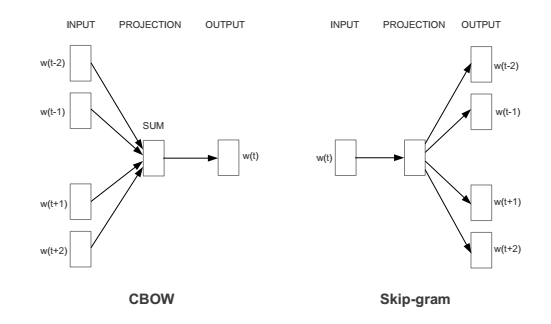

Doc2vec usa la misma lógica que word2vec, pero aplica esto al nivel del documento. De acuerdo con (Mikolov et al.2014), "cada párrafo se asigna a un vector único, representado por una columna en la matriz D y cada palabra también se asigna a un vector único, representado por una columna en la matriz W. El vector de párrafo y los vectores de palabras se promedian o concatenan para predecir la siguiente palabra en un contexto ... El token de párrafo puede considerarse como otra palabra. Actúa como un recuerdo que rememora lo que falta en el contexto actual, o el tema del párrafo ". https://cs.stanford.edu/~quocle/paragraph_vector.pdf

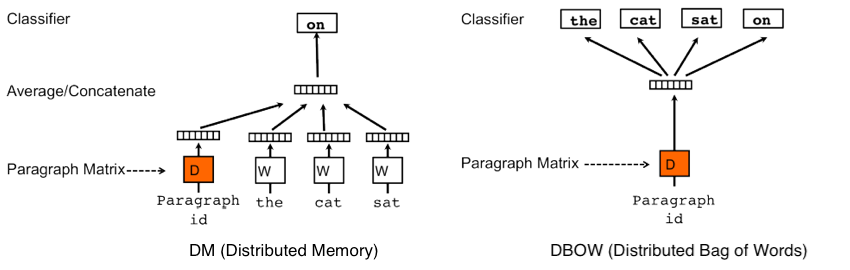

DM es el equivalente en DoctoVec a CBOW en Word2Vec así como análogamente ocurre con DBOW y Skip-gram

Para el desarrollo de los siguientes modelos me voy a apoyar en la librería Gensim. Existen muchas técnicas posibles a utilizar para la obtención de los vectores pero en este trabajo voy a presentar: <br>
1. DBOW (Distributed Bag of Words)<br>
2. DMC (Distributed Memory Concatenated)<br>

In [81]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [82]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result

Voy a utilizar todo el dataset para el entrenamiento del modelo siguiendo al lógica preentada en el tutorial de IMDB. https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

In [83]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_d2v = labelize_tweets_ug(all_x, 'all')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:

Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).



In [84]:
all_x_d2v

[LabeledSentence(words=['would', 'come', 'play', 'with', 'you', 'but', 'have', 'to', 'get', 'up', 'really', 'early', 'tomorrow'], tags=['all_455259']),
 LabeledSentence(words=['wtf', 'another', 'day', 'off', 'need', 'money'], tags=['all_472009']),
 LabeledSentence(words=['woke', 'up', 'with', 'nasty', 'cough', 'im', 'going', 'to', 'be', 'so', 'bummed', 'if', 'this', 'prevents', 'me', 'from', 'seeing', 'the', 'nephews', 'tomorrow'], tags=['all_568027']),
 LabeledSentence(words=['has', 'pint', 'of', 'guinness', 'raises', 'glass', 'to', 'emperix', 'happy', 'birthday', 'old', 'boy'], tags=['all_1122567']),
 LabeledSentence(words=['beethoven', 'is', 'on', 'tv', 'reminiscent', 'of', 'my', 'little', 'un', 'days'], tags=['all_1393805']),
 LabeledSentence(words=['saying', 'goodbye', 'to', 'of', 'my', 'friends', 'tonight', 'come', 'hangout', 'at', 'vibe', 'for', 'tour', 'kickoff'], tags=['all_357511']),
 LabeledSentence(words=['orlando', 'courtney', 'lee', 'pants'], tags=['all_459529']),
 Labele

## DBOW

In [47]:
model_ug_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2,  alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning:

The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.

100%|███████████████████████████████████████████████████████████████████| 1596020/1596020 [00:00<00:00, 4379382.74it/s]


In [48]:
%%time
for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_d2v)]), total_examples=len(all_x_d2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha

100%|███████████████████████████████████████████████████████████████████| 1596020/1596020 [00:00<00:00, 3757656.17it/s]


Wall time: 28min 28s


In [49]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [50]:
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
validation_vecs_dbow = get_vectors(model_ug_dbow, x_validation, 100)

In [51]:
train_vecs_dbow

array([[-0.10104948, -0.19317175, -0.27797556, ..., -0.31465089,
         0.38813701,  0.25189316],
       [-0.07090537, -0.1179624 ,  0.10829239, ..., -0.0412983 ,
         0.58198446, -0.94592738],
       [ 0.06285502, -0.35677123,  0.21809372, ..., -0.19648854,
         0.2668083 ,  0.70183092],
       ...,
       [-0.24999197, -0.19255322, -0.06954633, ..., -0.10772138,
         0.4995752 , -0.20524552],
       [ 0.21742845, -0.86087465,  0.54846108, ..., -0.12418914,
        -0.16215147, -0.37822431],
       [-0.1108639 , -0.22307158,  0.15615094, ..., -0.08278707,
         0.46241853,  0.00142502]])

In [52]:
clf = LogisticRegression()
clf.fit(train_vecs_dbow, y_train)

LogisticRegression()

In [96]:
D2Vec_DBOW=clf.score(validation_vecs_dbow, y_validation)
D2Vec_DBOW

0.7369674185463659

In [53]:

model_ug_dbow.save('.\Modelos Entrenados\d2v_model_ug_dbow.doc2vec')
model_ug_dbow = Doc2Vec.load('.\Modelos Entrenados\d2v_model_ug_dbow.doc2vec')

In [54]:
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## Distributed Memory (concatenated)

In [55]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_d2v)])

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning:

The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.

100%|███████████████████████████████████████████████████████████████████| 1596020/1596020 [00:00<00:00, 4019433.15it/s]


In [56]:
%%time
for epoch in range(30):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_d2v)]), total_examples=len(all_x_d2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha

100%|███████████████████████████████████████████████████████████████████| 1596020/1596020 [00:00<00:00, 3732765.91it/s]


Wall time: 34min 59s


In [57]:
model_ug_dmc = Doc2Vec.load('.\Modelos Entrenados\d2v_model_ug_dbow.doc2vec')

Utilizando los vectores automáticos inicializados aleatoriamente del modelo DBOW puro, sin significado voy a ver la relación semántica entre palabras pero con el modelo DM.

In [58]:
model_ug_dmc.most_similar('good')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('rupees', 0.3965798020362854),
 ('wwa', 0.3921608030796051),
 ('motz', 0.3914479613304138),
 ('nerimon', 0.3840712308883667),
 ('recipient', 0.3812514543533325),
 ('janeway', 0.3749181628227234),
 ('sharona', 0.3702771067619324),
 ('sait', 0.36695075035095215),
 ('offer', 0.36683472990989685),
 ('tawt', 0.36369848251342773)]

In [59]:
train_vecs_dmc = get_vectors(model_ug_dmc, x_train, 100)
validation_vecs_dmc = get_vectors(model_ug_dmc, x_validation, 100)

In [60]:
clf = LogisticRegression()
clf.fit(train_vecs_dmc, y_train)

LogisticRegression()

In [94]:
D2Vec_DMC=clf.score(validation_vecs_dmc, y_validation)

In [62]:
model_ug_dmc.save('.\Modelos Entrenados\d2v_model_ug_dmc.doc2vec')
model_ug_dmc = Doc2Vec.load('.\Modelos Entrenados\d2v_model_ug_dmc.doc2vec')
model_ug_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

### Carga de modelos entrenados

In [85]:
modelo_usw_cv=joblib.load('.\Modelos Entrenados\modelo_entrenado_usw_cv.pkl')
modelo_u_cv=joblib.load('.\Modelos Entrenados\modelo_entrenado_u_cv.pkl')
modelo_bsw_cv=joblib.load('.\Modelos Entrenados\modelo_entrenado_bsw_cv.pkl')
modelo_b_cv=joblib.load('.\Modelos Entrenados\modelo_entrenado_b_cv.pkl')
modelo_tsw_cv=joblib.load('.\Modelos Entrenados\modelo_entrenado_tsw_cv.pkl')
modelo_t_cv=joblib.load('.\Modelos Entrenados\modelo_entrenado_t_cv.pkl')
modelo_b_tfidf=joblib.load('.\Modelos Entrenados\modelo_entrenado_b_tfidf.pkl')
modelo_t_tfidf=joblib.load('.\Modelos Entrenados\modelo_entrenado_t_tfidf.pkl')
model_ug_dmc = Doc2Vec.load('.\Modelos Entrenados\d2v_model_ug_dmc.doc2vec')
model_ug_dbow = Doc2Vec.load('.\Modelos Entrenados\d2v_model_ug_dbow.doc2vec')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning:

Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning:

Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning:

Trying to unpickle estimator Pipeline from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning:

Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own ri

# Comparacion de los 10 modelos:

In [86]:
def baseModel_improvement_plot(modelo, x_train, y_train, x_test, y_test):
    ti = time()    
    y_pred = modelo.predict(x_test)
    train_test_time = time() - ti
    accuracy = accuracy_score(y_test, y_pred)
    accuracy=accuracy*100
    
    return accuracy, train_test_time

In [87]:
num_features = np.arange(10000,100001,10000)
def featureExtract_comparisson_plot(model):
    n_features=num_features
    result = []   
    for num in num_features:
        nfeature_accuracy,tt_time = baseModel_improvement_plot(model, x_train, y_train, x_validation, y_validation)
        result.append((num,nfeature_accuracy,tt_time))
    return result

In [89]:
result_UNIGRAM_STOPWORDS = featureExtract_comparisson_plot(modelo_usw_cv)
result_UNIGRAM_NOSTOPWORDS = featureExtract_comparisson_plot(modelo_u_cv)
result_BIGRAM_STOPWORDS = featureExtract_comparisson_plot(modelo_bsw_cv)
result_BIGRAM_NOSTOPWORDS = featureExtract_comparisson_plot(modelo_b_cv)
result_TRIGRAM_STOPWORDS = featureExtract_comparisson_plot(modelo_tsw_cv)
result_TRIGRAM_NOSTOPWORDS = featureExtract_comparisson_plot(modelo_t_cv)
result_BIGRAM_NOSTOPWORDS_TFIDF = featureExtract_comparisson_plot(modelo_b_tfidf)
result_TRIGRAM_NOSTOPWORDS_TFIDF = featureExtract_comparisson_plot(modelo_t_tfidf)



In [91]:
df_UNIGRAM_STOPWORDS = pd.DataFrame(result_UNIGRAM_STOPWORDS,columns=['features','val_accuracy','train_test_time'])
df_UNIGRAM_NOSTOPWORDS = pd.DataFrame(result_UNIGRAM_NOSTOPWORDS,columns=['features','val_accuracy','train_test_time'])
df_BIGRAM_STOPWORDS = pd.DataFrame(result_BIGRAM_STOPWORDS,columns=['features','val_accuracy','train_test_time'])
df_BIGRAM_NOSTOPWORDS = pd.DataFrame(result_BIGRAM_NOSTOPWORDS,columns=['features','val_accuracy','train_test_time'])
df_TRIGRAM_STOPWORDS = pd.DataFrame(result_TRIGRAM_STOPWORDS,columns=['features','val_accuracy','train_test_time'])
df_TRIGRAM_NOSTOPWORDS = pd.DataFrame(result_TRIGRAM_NOSTOPWORDS,columns=['features','val_accuracy','train_test_time'])
df_BIGRAM_NOSTOPWORDS_TFIDF = pd.DataFrame(result_BIGRAM_NOSTOPWORDS_TFIDF,columns=['features','val_accuracy','train_test_time'])
df_TRIGRAM_NOSTOPWORDS_TFIDF = pd.DataFrame(result_TRIGRAM_NOSTOPWORDS_TFIDF,columns=['features','val_accuracy','train_test_time'])


In [114]:
data = {'names': ['U_SW_V','U_NSW_V','B_SW_V','B_NSW_V','T_SW_V','T_NSW_V','B_NSW_T','T_NSW_T','D2Vec_DBOW','D2VeC_DMC'],
        'accuracy': [df_UNIGRAM_STOPWORDS["val_accuracy"][1],df_UNIGRAM_NOSTOPWORDS["val_accuracy"][1],
                     df_BIGRAM_STOPWORDS["val_accuracy"][1],df_BIGRAM_NOSTOPWORDS["val_accuracy"][1],
                    df_TRIGRAM_STOPWORDS["val_accuracy"][1],df_TRIGRAM_NOSTOPWORDS["val_accuracy"][1],
                    df_BIGRAM_NOSTOPWORDS_TFIDF["val_accuracy"][1],df_TRIGRAM_NOSTOPWORDS_TFIDF["val_accuracy"][1],D2Vec_DBOW*100,D2Vec_DMC*100]
        }

df = pd.DataFrame(data, columns = ['names', 'accuracy'])
df

names   accuracy
0      U_SW_V  77.907268
1     U_NSW_V  79.774436
2      B_SW_V  78.533835
3     B_NSW_V  81.860902
4      T_SW_V  78.446115
5     T_NSW_V  82.224311
6     B_NSW_T  82.349624
7     T_NSW_T  82.337093
8  D2Vec_DBOW  73.696742
9   D2VeC_DMC  73.696742

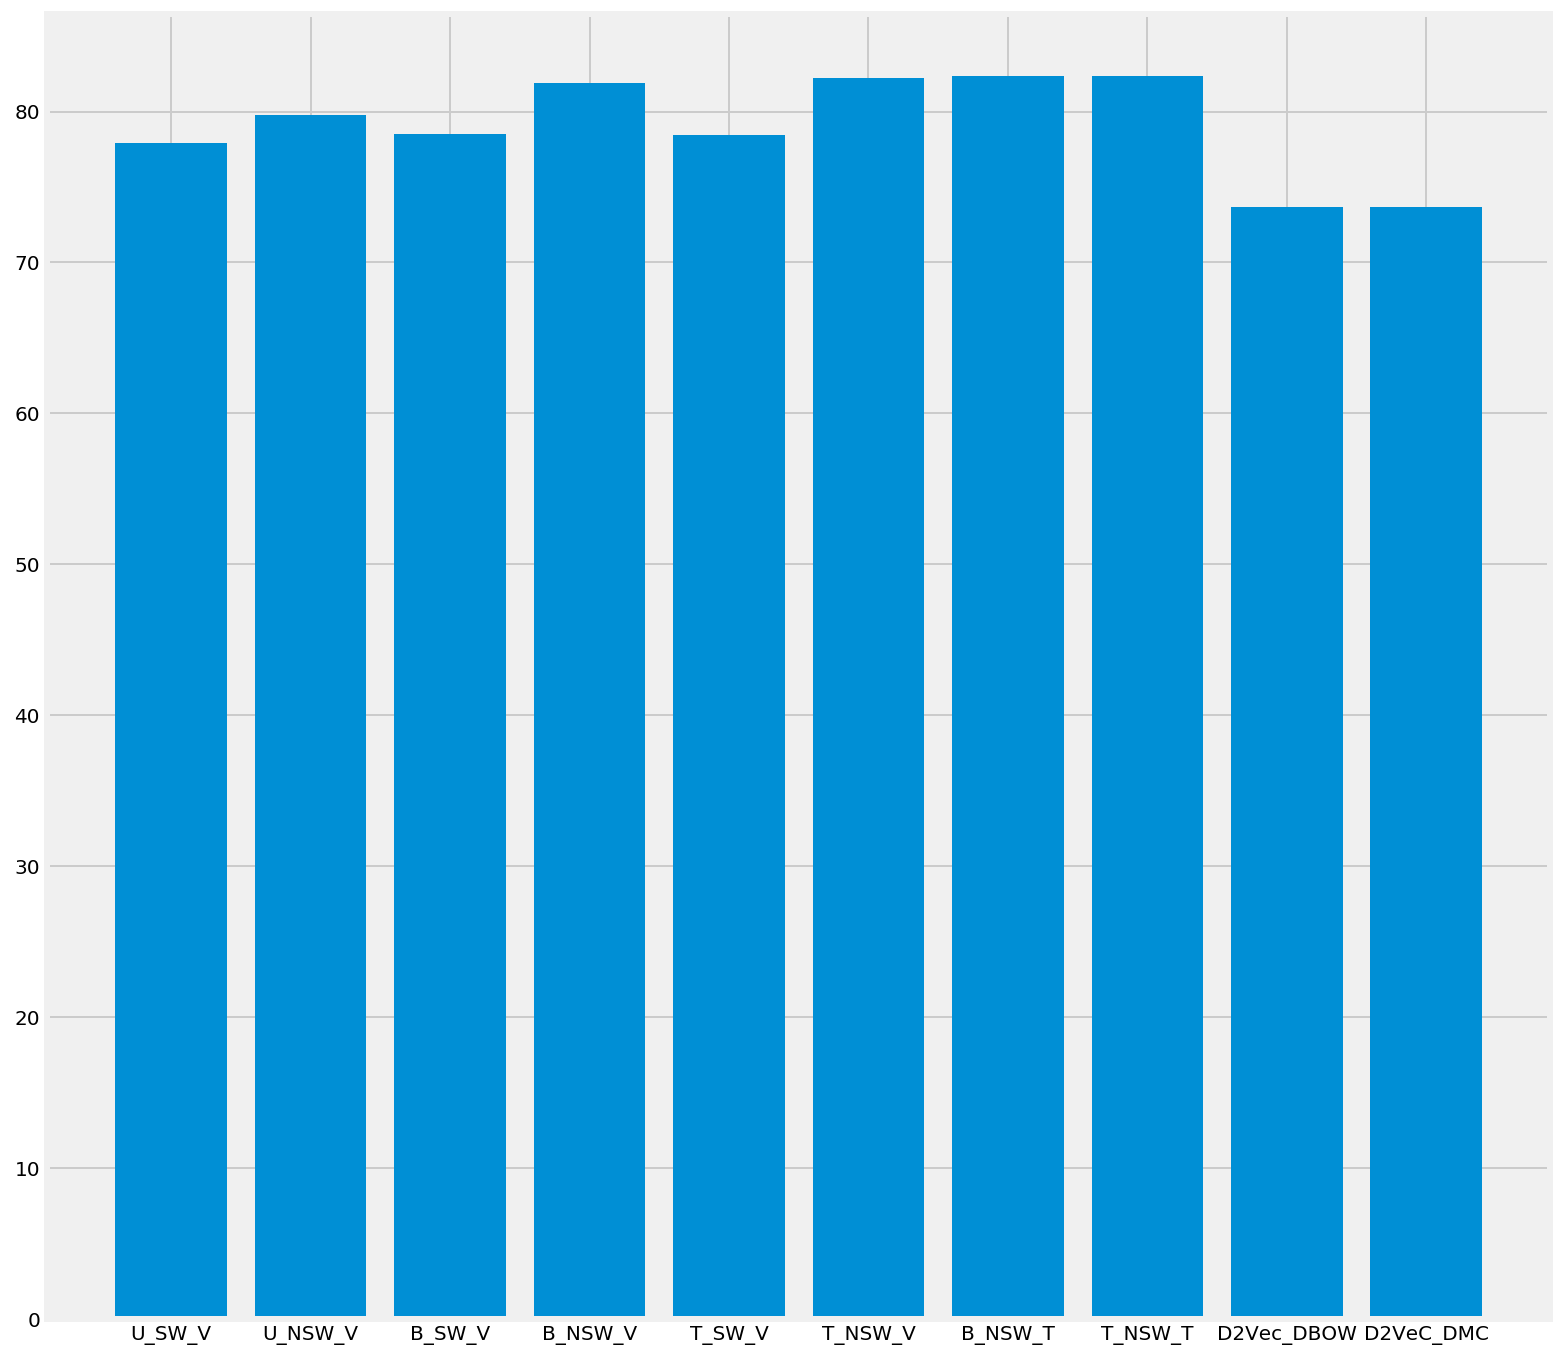

In [115]:
plt.figure(figsize=(12,12))
plt.bar(df.names,df["accuracy"])
plt.show()

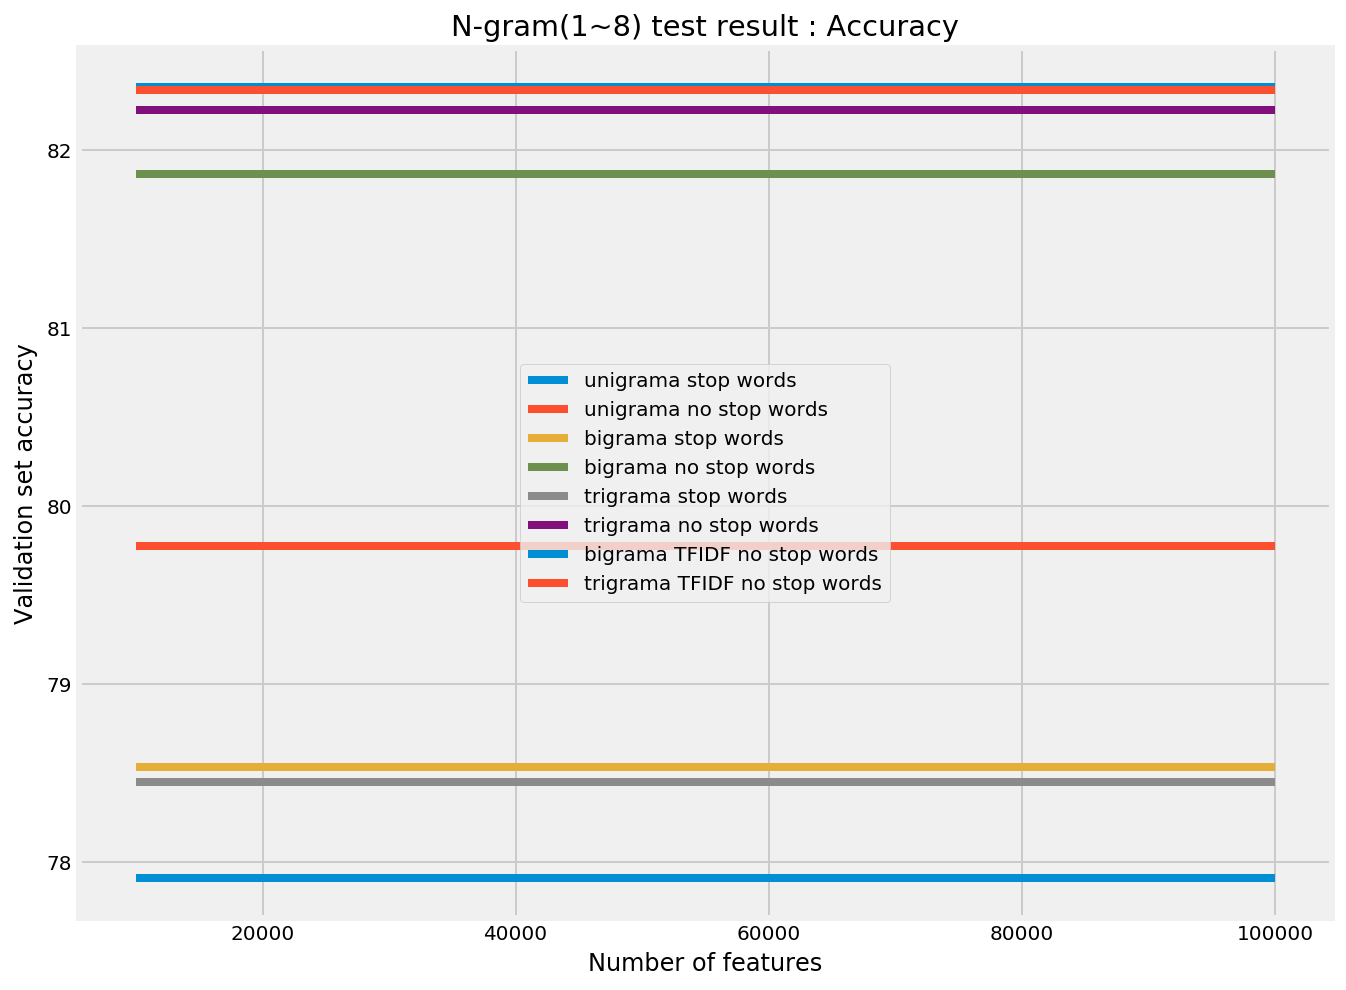

In [116]:
plt.figure(figsize=(10,8))
plt.plot(df_UNIGRAM_STOPWORDS.features, df_UNIGRAM_STOPWORDS.val_accuracy,label='unigrama stop words')
plt.plot(df_UNIGRAM_NOSTOPWORDS.features, df_UNIGRAM_NOSTOPWORDS.val_accuracy,label='unigrama no stop words')
plt.plot(df_BIGRAM_STOPWORDS.features, df_BIGRAM_STOPWORDS.val_accuracy, label='bigrama stop words')
plt.plot(df_BIGRAM_NOSTOPWORDS.features, df_BIGRAM_NOSTOPWORDS.val_accuracy,label='bigrama no stop words')
plt.plot(df_TRIGRAM_STOPWORDS.features, df_TRIGRAM_STOPWORDS.val_accuracy,label='trigrama stop words')
plt.plot(df_TRIGRAM_NOSTOPWORDS.features, df_TRIGRAM_NOSTOPWORDS.val_accuracy, label='trigrama no stop words')
plt.plot(df_BIGRAM_NOSTOPWORDS_TFIDF.features, df_BIGRAM_NOSTOPWORDS_TFIDF.val_accuracy, label='bigrama TFIDF no stop words')
plt.plot(df_TRIGRAM_NOSTOPWORDS_TFIDF.features, df_TRIGRAM_NOSTOPWORDS_TFIDF.val_accuracy, label='trigrama TFIDF no stop words')
plt.title("N-gram(1~8) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()